# Reinforcement Learning
Prof. S. Harmeling

### Double Q-learning

In this notebook we will implement double Q-learning, which uses two Q-functions $Q_1$ and $Q_2$, one for action selection, the other for the target value. During training, the roles of of $Q_1$ and $Q_2$ are alternated.

The update rule for $Q_1$ is:
$$
Q_1(s_t,a_t) \leftarrow Q_1(s_t,a_t) + \alpha (r_{t+1} + \gamma Q_2(s_{t+1}, \arg\max_{a'} Q_1(s_{t+1},a')) - Q_1(s_1, a_t))
$$
The update rule for $Q_2$ is:
$$
Q_2(s_t,a_t) \leftarrow Q_2(s_t,a_t) + \alpha (r_{t+1} + \gamma Q_1(s_{t+1}, \arg\max_{a'} Q_2(s_{t+1},a')) - Q_2(s_1, a_t))
$$

For the implementation, there are two missing details:
- When do we update $Q_1$ and when $Q_2$?
- Which action values do we use for $\epsilon$-greedy action selection?

In this notebook, we will flip a coin to update either $Q_1$ or $Q_2$ with $50\%$ probability.  
The action values that are used for action selection are the average of $Q_1$ and $Q_2$.  
To implement this, we will store a third Q-function $Q$, which gets updated every time when we update $Q_1$ or $Q_2$ with the following update rule:
$$
Q(s_t,a_t) \leftarrow (Q_1(s_t,a_t) + Q_2(s_t,a_t)) / 2
$$

#### Implementation

Make sure that the files `rl_agent.py`, `rl_env.py` and `rl_tests.py` are in the same folder as the notebook.

In [1]:
%load_ext autoreload
%autoreload 2

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

import rl_agent
import rl_env
import rl_tests

Implement double Q-learning as described above.

In [2]:
class DoubleQLearningAgent(rl_agent.TabularAgent):

    def __init__(self, env, gamma, epsilon, alpha, rng=None):
        super().__init__(env)
        self.gamma = gamma      # discount factor
        self.epsilon = epsilon  # epsilon-greedy probability
        self.alpha = alpha      # learning rate
        self.rng = rng if rng is not None else np.random.default_rng()
        self.reset()

    def reset(self):
        # Create arrays for action values
        self.q1 = np.zeros((self.num_states, self.num_actions), dtype=float)
        self.q2 = np.zeros((self.num_states, self.num_actions), dtype=float)
        self.q = np.zeros((self.num_states, self.num_actions), dtype=float)
        # Create array for policy distribution (initialized uniformly)
        self.pi = np.full((self.num_states, self.num_actions), 1 / self.num_actions)

    def policy(self, state):
        # Sample an action according to pi
        action_probs = self.pi[state]
        action = self.rng.choice(self.num_actions, p=action_probs)
        return action

    def value(self, state):
        # Compute the state value from q and pi
        return np.sum(self.pi[state] * self.q[state])

    def action_value(self, state, action):
        # Lookup the action value in q
        return self.q[state, action]

    def policy_evaluation(self, state, action, reward, next_state, terminated, truncated):
        alpha = self.alpha
        gamma = self.gamma
        q = self.q
        q1 = self.q1
        q2 = self.q2

        #######################################################################
        # TODO Perform one step of policy evaluation. Use `self.rng.random()` #
        # to decide which Q-function is updated (it returns a random value    #
        # between 0 and 1). Also update `q` as described above. Remember to   #
        # check whether the episode is terminated.                            #
        #######################################################################
        
        coin_flip = self.rng.random()
        if coin_flip < 0.5:
            # we update Q1
            argmax_a = q1[next_state, :].argmax()
            target = reward + int(not terminated) * gamma * q2[next_state, argmax_a]
            self.q1[state, action] += alpha * (target - q1[state, action])
        else:
            # we update Q2
            argmax_a = q2[next_state, :].argmax()
            target = reward + int(not terminated) * gamma * q1[next_state, argmax_a]
            self.q2[state, action] += alpha * (target - q2[state, action])
            
        self.q = (q1 + q2) / 2
        

    def policy_improvement(self):
        # Update the policy using epsilon-greedy policy improvement
        q = self.q
        epsilon = self.epsilon

        # Find the maximizing actions
        max_q = np.max(q, axis=1, keepdims=True)
        max_mask = q == max_q
        num_max = np.sum(max_mask, axis=1, keepdims=True)

        # Compute the probabilities
        num_actions = q.shape[1]
        pi = ((1 - epsilon) / num_max) * max_mask
        pi += epsilon / num_actions
        self.pi = pi

You can use the following code cell to test your implementation.  
**Important**: After changing your code, execute the above code cell before running the tests.

In [3]:
def test_double_q_learning_agent():
    env = rl_env.MaximizationBiasEnv(num_actions=10)
    rng = None

    def seed(offset=0):
        nonlocal rng
        rng = np.random.Generator(np.random.PCG64(seed=42 + offset))
        env.reset(seed=42 + offset)

    def create_agent(gamma, epsilon, alpha):
        return DoubleQLearningAgent(env, gamma, epsilon, alpha, rng=rng)

    yield 'policy_evaluation()'
    seed()
    state, _ = env.reset()
    for expected_sum in [0.8329420394580342, -0.5262261767947287, 0.7997062230980709]:
        agent = create_agent(gamma=0.8, epsilon=0.01, alpha=0.1)
        for _ in range(10):
            s, next_s = [rng.integers(0, agent.num_states) for _ in range(2)]
            a = rng.integers(0, agent.num_actions)
            r = rng.uniform(-5.0, 5.0)
            agent.policy_evaluation(s, a, r, next_s, False, False)

        if (yield from rl_tests.check_numpy_array(agent.q, name='self.q', shape=(agent.num_states, agent.num_actions), dtype=np.floating)):
            q_sum = np.sum(agent.q)
            yield np.isclose(q_sum, expected_sum, atol=1e-5), f'The updated action values are incorrect (error = {abs(expected_sum - q_sum):.5f})'
        yield None

rl_tests.run_tests(test_double_q_learning_agent())

Testing policy_evaluation()...
3/3 tests passed!


#### Evaluation

Now we evaluate double Q-learning and Q-learning on the simple environment from Figure 6.5 in the textbook http://incompleteideas.net/book/the-book-2nd.html  
which we have already seen in the lecture.

We have already implemented everything below.

First, the Q-learning agent for comparison:

In [4]:
class QLearningAgent(rl_agent.TabularAgent):

    def __init__(self, env, gamma, epsilon, alpha, rng=None):
        super().__init__(env)
        self.gamma = gamma      # discount factor
        self.epsilon = epsilon  # epsilon-greedy probability
        self.alpha = alpha      # learning rate
        self.rng = rng if rng is not None else np.random.default_rng()
        self.reset()

    def reset(self):
        # Create array for action values
        self.q = np.zeros((self.num_states, self.num_actions), dtype=float)
        # Create array for policy distribution (initialized uniformly)
        self.pi = np.full((self.num_states, self.num_actions), 1 / self.num_actions)

    def policy(self, state):
        # Sample an action according to pi
        action_probs = self.pi[state]
        action = self.rng.choice(self.num_actions, p=action_probs)
        return action

    def value(self, state):
        # Compute the state value from q and pi
        return np.sum(self.pi[state] * self.q[state])

    def action_value(self, state, action):
        # Lookup the action value in q
        return self.q[state, action]

    def policy_evaluation(self, state, action, reward, next_state, terminated, truncated):
        # Update the action value with the Q-learning update

        if terminated:
            target = reward
        else:
            target = reward + self.gamma * np.max(self.q[next_state])

        q = self.q
        q[state, action] += self.alpha * (target - q[state, action])

    def policy_improvement(self):
        # Update the policy using epsilon-greedy policy improvement
        q = self.q
        epsilon = self.epsilon

        # Find the maximizing actions
        max_q = np.max(q, axis=1, keepdims=True)
        max_mask = q == max_q
        num_max = np.sum(max_mask, axis=1, keepdims=True)

        # Compute the probabilities
        num_actions = q.shape[1]
        pi = ((1 - epsilon) / num_max) * max_mask
        pi += epsilon / num_actions
        self.pi = pi

The following two code cells evaluate both agents on the environment:

In [5]:
def evaluate_agent(env, agent, num_episodes):
    # Train the agent and return the first action from each episode.

    first_actions = []

    # In state 2 (A), there are only two valid actions, so we manually
    # update `pi` to only choose `left` or `right`.

    def correct_pi():
        agent.pi[2, 2:] = 0.0
        agent.pi[2] /= agent.pi[2, :2].sum()

    correct_pi()

    # The usual training loop
    for _ in range(num_episodes):
        state, _ = env.reset()
        action = agent.policy(state)
        first_actions.append(action)

        while True:
            next_state, reward, terminated, truncated, _ = env.step(action)
            agent.policy_evaluation(state, action, reward, next_state, terminated, truncated)
            agent.policy_improvement()
            correct_pi()
            if terminated or truncated:
                break
            state = next_state
            action = agent.policy(state)

    return first_actions

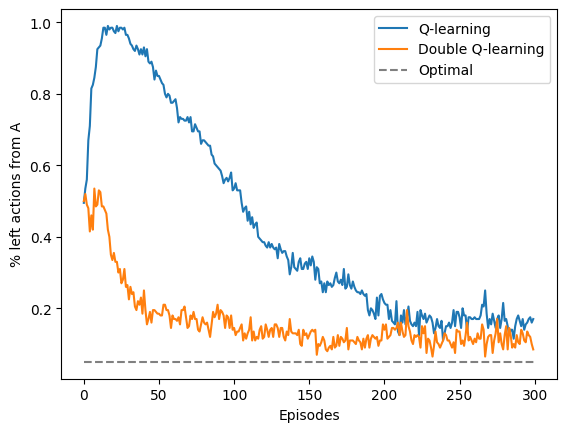

In [6]:
env = rl_env.MaximizationBiasEnv(num_actions=10)
gamma = 1.0    # discount factor
epsilon = 0.1  # epsilon-greedy probability
alpha = 0.1    # learning rate
num_runs = 200  # average over multiple runs
num_episodes = 300  # number of episodes for training

# Store the first action of each episode
q_learning_first_actions = np.zeros((num_runs, num_episodes))
double_q_learning_first_actions = np.zeros((num_runs, num_episodes))

for i in range(num_runs):
    agent = QLearningAgent(env, gamma, epsilon, alpha)
    q_learning_first_actions[i] = evaluate_agent(env, agent, num_episodes)

    agent = DoubleQLearningAgent(env, gamma, epsilon, alpha)
    double_q_learning_first_actions[i] = evaluate_agent(env, agent, num_episodes)

# Compute average over the runs
q_learning_first_actions = np.mean(q_learning_first_actions, 0)
double_q_learning_first_actions = np.mean(double_q_learning_first_actions, 0)

# Plot the results
plt.xlabel('Episodes')
plt.ylabel('% left actions from A')
plt.plot(1 - q_learning_first_actions, label='Q-learning')
plt.plot(1 - double_q_learning_first_actions, label='Double Q-learning')
plt.hlines(y=0.05, xmin=0, xmax=num_episodes, linestyle='--', color='gray', label='Optimal')
plt.legend();